In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
data_dir = "data"
train_data_path = os.path.join(data_dir, "train.csv")
test_data_path  = os.path.join(data_dir, "test.csv")
graph_data_path = os.path.join(data_dir, "graph.csv")

In [6]:
# https://gist.github.com/rogerallen/1583593
# ^ Use this in case we need state code translation

from sklearn.preprocessing import StandardScaler

import math
import matplotlib.pyplot as plt
class utils:
    def __init__(self):
        pass
    
    def split(self, dataframe, test=0.2):
        size = dataframe.shape
        train_size = size[0] - math.floor(size[0] * test)
        return dataframe[:train_size], dataframe[train_size:]
    
class CoreData(object):
    def __init__(self, data_path = None, debug=False):
        if not data_path:
            raise Exception("Input file path!")
        self.data_path = data_path
        self.df = None
        self.states = []
        self.state_df = {}
        self.debug = debug
        
    def load(self, normalize=True):
        '''
        DataProcessor.load()
        Pre-load data state-by-state to a dictionary.
        '''
        # Change this line to modify dropped data series.
        dropped_col = ['Date', 'ID', 'Province_State']
        
        self.df = pd.read_csv(train_data_path)
        self.states = list(np.unique(self.df['Province_State']))
        self.state_df = dict.fromkeys(self.states, None)
        
        for s in self.states:
            df_filter = self.df['Province_State'] == s
            tmp_state_df = self.df[df_filter]
            self.state_df[s] = tmp_state_df.drop(dropped_col, 1)
            
            # Normalize
            if normalize:
                mean = self.state_df[s].mean()
                std = self.state_df[s].std()
                self.state_df[s] = (self.state_df[s] - mean)/std
    
    def access(self, state=None):
        if not state:
            raise Exception('Enter state name! i.e. self.access("California")')
        elif state not in self.states:
            raise Exception('Check your spelling of the state.')
        return self.state_df[state]
    
    def access_split(self, state=None, test_portion=0.2):
        df = self.access(state)
        return utils().split(dataframe=df, test=test_portion)


In [7]:
dp = CoreData(train_data_path)

In [9]:
dp.load()

In [51]:
dp.access("California")

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
4,-1.122550,-1.562561,NaN,-1.115248,-1.122531,-1.198505,0.820443,-0.104990,-1.198733,2.194601
54,-1.117407,-1.541225,NaN,-1.110364,-1.117346,-1.198346,-3.581704,0.089651,-1.198573,-0.666006
104,-1.110956,-1.525943,NaN,-1.104055,-1.110842,-1.195096,0.679590,0.135186,-1.195297,1.477098
154,-1.104934,-1.499129,NaN,-1.098367,-1.104772,-1.191000,0.679590,0.353978,-1.191167,1.196952
204,-1.100447,-1.471449,NaN,-1.094251,-1.100249,-1.182417,0.417723,0.610197,-1.182515,0.874057
...,...,...,...,...,...,...,...,...,...,...
6854,1.906439,1.908029,NaN,1.905930,1.906772,1.879640,NaN,-1.189978,1.879924,NaN
6904,1.931630,1.944935,NaN,1.930928,1.931972,1.906101,NaN,-1.185842,1.906393,NaN
6954,1.952696,1.970596,NaN,1.951916,1.953046,1.934505,NaN,-1.185279,1.934805,NaN
7004,1.970412,1.982994,NaN,1.969712,1.970768,1.969566,NaN,-1.189808,1.969878,NaN


In [52]:
t = dp.access_split('California')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# 后面抄的 `notebook.ipynb`

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

state='New York'

X_train = []
y_train = []

window_size = 14
forecast_day = 27

train_data = dp.access_split(state)[0]
train_data = np.array(train_data)

for i in range(window_size, train_data.shape[0]-forecast_day):
    X_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i+forecast_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(73, 14, 10)

In [57]:
model = keras.Sequential()

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 200, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [58]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

In [60]:
previous_days = dp.access_split(state)[0].tail(window_size+forecast_day)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [61]:
inputs = np.array(previous_days)

In [62]:
X_test = []
y_test = []

for i in range(window_size, inputs.shape[0]):
    X_test.append(inputs[i-window_size:i])
    y_test.append(inputs[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [63]:
y_pred = model.predict(X_test)

In [64]:
y_result = y_pred.flatten().tolist()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


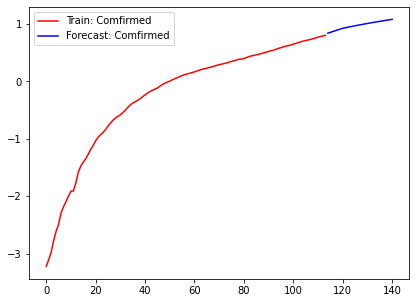

In [68]:
import matplotlib.pyplot as plt
num_state_train = dp.access_split(state)[0].shape[0]
forecast_range = np.arange(num_state_train, num_state_train+forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(dp.access_split(state)[0].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(forecast_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

In [14]:

window_size = 14
forecast_day = 27

models = {}
for c, state in enumerate(dp.states, 1):
    print(f"Processing {c}/{len(dp.states)}: {state}...")
    X_train = []
    y_train = []

    train_data = dp.access_split(state)[0]
    train_data = np.array(train_data)

    for i in range(window_size, train_data.shape[0]-forecast_day):
        X_train.append(train_data[i-window_size:i])
        y_train.append(train_data[i+forecast_day, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    
    model = keras.Sequential()

    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 200, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
    
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    
    models[state] = model
    
    

Processing 1/50: Alabama...
Processing 2/50: Alaska...
Processing 3/50: Arizona...
Processing 4/50: Arkansas...
Processing 5/50: California...
Processing 6/50: Colorado...
Processing 7/50: Connecticut...
Processing 8/50: Delaware...
Processing 9/50: Florida...
Processing 10/50: Georgia...
Processing 11/50: Hawaii...
Processing 12/50: Idaho...
Processing 13/50: Illinois...
Processing 14/50: Indiana...
Processing 15/50: Iowa...
Processing 16/50: Kansas...
Processing 17/50: Kentucky...
Processing 18/50: Louisiana...
Processing 19/50: Maine...
Processing 20/50: Maryland...
Processing 21/50: Massachusetts...
Processing 22/50: Michigan...
Processing 23/50: Minnesota...
Processing 24/50: Mississippi...
Processing 25/50: Missouri...
Processing 26/50: Montana...
Processing 27/50: Nebraska...
Processing 28/50: Nevada...
Processing 29/50: New Hampshire...
Processing 30/50: New Jersey...
Processing 31/50: New Mexico...
Processing 32/50: New York...
Processing 33/50: North Carolina...
Processing 34

In [16]:
for state in dp.states:
    
    model = models[state]

    previous_days = dp.access_split(state)[0].tail(window_size+forecast_day)
    inputs = np.array(previous_days)
    X_test = []
    y_test = []

    for i in range(window_size, inputs.shape[0]):
        X_test.append(inputs[i-window_size:i])
        y_test.append(inputs[i,0])

    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test)
    print(state, y_pred)
    y_result = y_pred.flatten().tolist()
    print(y_result)
    break

Alabama [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [23]:
state = "New York"
model = models[state]

previous_days = dp.access_split(state)[0].tail(window_size+forecast_day)
inputs = np.array(previous_days)
X_test = []
y_test = []

for i in range(window_size, inputs.shape[0]):
    X_test.append(inputs[i-window_size:i])
    y_test.append(inputs[i,0])


X_test, y_test = np.array(X_test), np.array(y_test)
    
y_pred = model.predict(X_test)
print(state, y_pred)
y_result = y_pred.flatten().tolist()
print(y_result)

New York [[0.8266793 ]
 [0.8423314 ]
 [0.8576897 ]
 [0.87289304]
 [0.8882656 ]
 [0.90354747]
 [0.9179762 ]
 [0.92874813]
 [0.9394484 ]
 [0.94981164]
 [0.9593652 ]
 [0.9689189 ]
 [0.9784492 ]
 [0.9882381 ]
 [0.99805623]
 [1.0078875 ]
 [1.0176523 ]
 [1.0271331 ]
 [1.0366396 ]
 [1.0463129 ]
 [1.0558351 ]
 [1.0651349 ]
 [1.0742232 ]
 [1.0831944 ]
 [1.0920032 ]
 [1.1007282 ]
 [1.109491  ]]
[0.8266792893409729, 0.8423314094543457, 0.8576896786689758, 0.8728930354118347, 0.8882656097412109, 0.903547465801239, 0.9179762005805969, 0.9287481307983398, 0.9394484162330627, 0.9498116374015808, 0.95936518907547, 0.9689189195632935, 0.9784492254257202, 0.9882380962371826, 0.9980562329292297, 1.0078874826431274, 1.0176522731781006, 1.0271331071853638, 1.0366395711898804, 1.046312928199768, 1.0558351278305054, 1.065134882926941, 1.0742231607437134, 1.083194375038147, 1.0920032262802124, 1.100728154182434, 1.109490990638733]


In [25]:
print(models.values())

dict_values([<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8fa9b9b20>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8db63e2b0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8db0e6100>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8e0b7b040>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8cd8c4370>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8cd69ef10>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8da107fa0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8bf5ddbe0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8c4b2cac0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8ab3dadc0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8ab3cc760>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc8b2c2eee0>, <tensorflow.pyt